## Build model via Functional API

### When to use?

Keras 函數式 API 是一種比 tf.keras.Sequential API 更靈活的建立模型的方法。函數式 API 能夠處理具有非線性拓撲結構(non-linear topology)、共享層（shared layers），甚至多個輸入或輸出的模型。

其主要思想是，深度學習模型通常是一個層的 有向無環圖（Directed Acyclic Graph，DAG）。因此，函數式 API 提供了一種構建層圖的方法。

考慮以下模型：

(input: (28, 28)-dimensional vectors) \
&emsp;&emsp; ↧\
[Flatten]\
&emsp;&emsp; ↧\
[Dense (128 units, relu activation)]\
&emsp;&emsp; ↧\
[Dropout]\
&emsp;&emsp; ↧\
[Dense (10 units, softmax activation)]\
&emsp;&emsp; ↧\
(output: logits of a probability distribution over 10 classes)


這是一個具有四個層的基本圖。使用函數式 API 構建這個模型的方式是，首先創建一個輸入節點：

In [2]:
import tensorflow as tf
inputs = tf.keras.Input(shape=(28, 28))

數據的形狀被設置為一個 784 維的向量。由於只指定了每個樣本的形狀，批次大小（batch size）通常被省略。inputs 返回的對象包含有關將餵入模型的輸入數據的形狀和數據類型（dtype）的信息。

In [3]:
print("Shape:", inputs.shape)
print("dtype:", inputs.dtype)

Shape: (None, 28, 28)
dtype: <dtype: 'float32'>


You create a new node in the graph of layers by calling a layer on this inputs object. The "layer call" action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get x as the output.

Let's add a few more layers to the graph of layers:

In [4]:
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(10)(x)

At this point, you can create a Model by specifying its inputs and outputs in the graph of layers:

In [5]:
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Training, evaluation, and inference work exactly in the same way for models built using the functional API as for Sequential models.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

In [ ]:
# Destroys the current TF graph and creates a new one.
tf.keras.backend.clear_session()

## Build model via Model Subclassing

### When to use?

模型子類別化（Model Subclassing）是實現模型架構的最後一種方法。模型子類別化是完全可定制的，使你能夠實現自己定制的模型前向傳播。然而，這種靈活性和定制性是有代價的 —— 模型子類別化要比順序 API 或函數式 API 更難使用。

那麼，如果模型子類別化方法如此難以使用，為什麼還要使用它呢？

異常的結構或自定義的層/模型實現，特別是那些由研究人員使用的，可能非常具有挑戰性，甚至可能無法使用標準的順序或函數式 API 實現。相反，研究人員希望對網絡和訓練過程的每一個細節都有掌控權 — 這正是模型子類別化為他們提供的。

使用 tf.data 對數據集進行批處理和洗牌（batch and shuffle）：

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Build the tf.keras model using the Keras model subclassing API:

In [7]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.d1 = tf.keras.layers.Dense(128, activation='relu')
        self.d2 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        x = self.dropout(x)
        return self.d2(x)

In [8]:
# Create an instance of the model
model = MyModel()
model.build(input_shape=(None, 28, 28))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  100480    
                                                                 
 dense_3 (Dense)             multiple                  1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Choose an optimizer and loss function for training.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()


選擇用於測量模型損失和準確度的指標。這些指標會在每個 epoch 積累值，然後打印整體結果。

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

To train the model, we can use **tf.GradientTape** to record operations for automatic differentiation.

深度學習框架中一個最重要且強大的功能是自動微分和梯度。正如在[《Neural Networks from Scratch》](https://nthu-datalab.github.io/ml/labs/10_TensorFlow101/10_NN-from-Scratchs.html)中所看到的，手動構建神經網絡需要對反向傳播算法有深刻的了解，需要計算所有東西的導數。這在操作不太多或模型結構相對簡單的情況下可能很有趣。但是，當有數千萬個操作或更複雜的結構時，對每個權重計算梯度將會是一場噩夢。

TensorFlow 提供了 tf.GradientTape API 來進行自動微分；也就是計算相對於某些輸入（通常是 tf.Variable）的計算梯度，這對於實現機器學習算法，如訓練神經網絡的反向傳播，非常有用。簡而言之，你可以將 tape.gradient(loss, model.trainable_variable) 看作是：

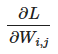

For more details, please refer to [Introduction to Gradients and Automatic Differentiation](https://www.tensorflow.org/guide/autodiff)

In [ ]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


請注意，由 tf.function 裝飾的函數將自動編譯為可調用的 TensorFlow 圖（graph）。這使得 TensorFlow 運行時能夠應用優化並利用並行處理來提升計算性能。我們將在後面的部分更詳細地討論 tf.function。


Let's train and evaluate the model first.

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
        
    template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f}'
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result()*100,
                           test_loss.result(),
                           test_accuracy.result()*100))

#### Sequential API, Functional API, and Model Subclassing

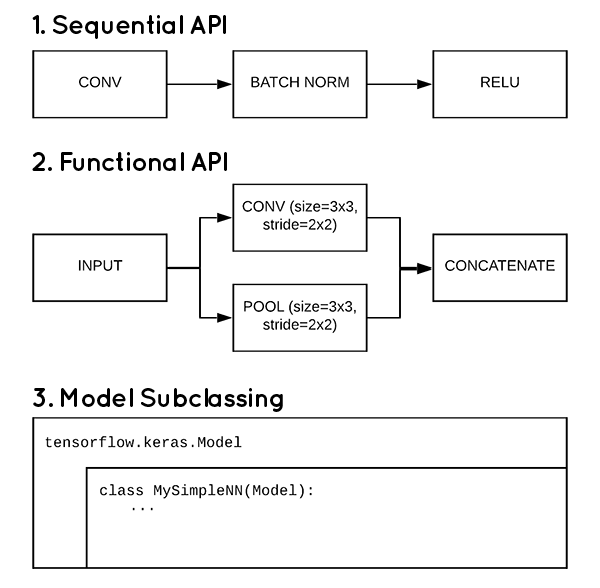

應該使用 Keras 函數式 API 來創建一個新模型，還是直接對 Model 類進行子類別化呢？一般來說，函數式 API 更高階、更容易和更安全，並且具有一些子類別模型不支持的功能。然而，模型子類別化在構建不能很容易表示為層的有向無環圖的模型時提供了更大的靈活性。例如，你無法使用函數式 API 實現 Tree-RNN，必須直接對 Model 進行子類別化。

在函數式 API 和模型子類別化之間的選擇並不是一個將你限制在一類模型中的二進制決策。在 tf.keras API 中，所有模型都可以相互交互，無論它們是順序模型、函數模型還是從頭開始編寫的子類模型。

要深入了解函數式 API 和模型子類別化之間的差異，請閱讀[《What are Symbolic and Imperative APIs in TensorFlow 2.0?》](https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html)。

## Better performance with tf.function

在 TensorFlow 2 中，即時執行（eager execution）默認為開啟狀態。這使得用戶界面直觀靈活（運行一次性操作更加輕鬆和快速），但這可能會以性能和可部署性為代價。

你可以使用 tf.function 將你的程序轉換為圖形。這是一個轉換工具，它可以將你的 Python 代碼轉換為獨立於 Python 的數據流圖。在這裡，我們將簡要介紹 tf.function 的工作原理，以便你能夠有效地使用它。

主要的要點和建議如下：
- Debug in eager mode, then decorate with @tf.function.
- Don't rely on Python side effects like object mutation or list appends.。
- tf.function works best with TensorFlow ops; NumPy and Python calls are converted to constants.

讓我們創建兩個具有相同操作的函數。f_eager 和 f_graph 分別表示在即時執行模式和圖形模式運行的函數。

In [9]:
def f_eager(x, y):
    for i in tf.range(100000):
        _ = tf.reduce_mean(tf.multiply(x ** 2, 3) + y)
    return tf.reduce_mean(tf.multiply(x ** 2, 3) + y)

@tf.function
def f_graph(x, y):
    for i in tf.range(100000):
        _ = tf.reduce_mean(tf.multiply(x ** 2, 3) + y)
    return tf.reduce_mean(tf.multiply(x ** 2, 3) + y)

In [10]:
x = tf.constant([[2.0, 3.0]])
y = tf.constant([[3.0, -2.0]])

In [11]:
# `f_eager` and `f_graph` return same values, but `f_graph` is executed as a TensorFlow graph.
assert f_eager(x, y).numpy() == f_graph(x, y).numpy()

In [12]:
%time _ = f_eager(x, y)

CPU times: total: 1min 36s
Wall time: 1min 36s


In [13]:
%time _ = f_graph(x, y)

CPU times: total: 0 ns
Wall time: 1 ms


正如你所看到的，使用 @tf.function 裝飾的函數可能比即時執行的代碼更快，特別是對於包含許多小操作的圖形。但對於包含一些昂貴操作（例如卷積）的圖形，你可能不會看到太大的加速。

如果你的代碼使用多個函數，你不需要對它們全部進行裝飾 - 從一個被裝飾的函數調用的任何函數也將在圖形模式下運行。因此，你只需要對最外層的函數進行裝飾即可。

### Debugging


一般來說，在即時執行模式下進行調試代碼比在 tf.function 內部更容易。在使用 tf.function 裝飾之前，應確保代碼在即時執行模式下可以無錯運行。為了在調試過程中提供幫助，你可以調用 tf.config.run_functions_eagerly(True) 以全局禁用和重新啟用 tf.function。

當追蹤僅在 tf.function 內部出現的問題時，以下是一些建議：
- Plain old Python print calls only execute during tracing, helping you track down when your function gets (re)traced.
- tf.print calls will execute every time, and can help you track down intermediate values during execution.
- tf.debugging.enable_check_numerics is an easy way to track down where NaNs and Inf are created.
- pdb can help you understand what's going on during tracing. (Caveat: PDB will drop you into AutoGraph-transformed source code.)

### Python side effects

Python 的副作用，如打印、向列表附加和變更全局變量，僅在第一次使用一組輸入調用函數時發生。之後，追蹤的 tf.Graph 重新執行，而不執行 Python 代碼。

一般的經驗法則是僅使用 Python 的副作用來調試你的追蹤。否則，TensorFlow 操作，如 tf.Variable.assign、tf.print 和 tf.summary，是確保你的代碼將在每次調用時被追蹤和由 TensorFlow 運行時執行的最佳方式。

In [ ]:
@tf.function
def f(x):
    print("Traced with", x)
    tf.print("Executed with", x)

In [ ]:
f(1)
f(1)
f(2)

As we can see, print function works unexpectedly, while tf.print calls execute every time. Another gotcha we can see below is mutating globals.

In [ ]:
g = 0

@tf.function
def mutate_globals(x):
    return x + g

# tf.function captures the value of the global during the first run
print("First call: ", mutate_globals(tf.constant(1)))
g = 10  # Update the global

# Subsequent runs may silently use the cached value of the globals
print("Second call: ", mutate_globals(tf.constant(2)))

# tf.function re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print("Third call, different type: ", mutate_globals(tf.constant([4.])))

In addition, many Python features, such as generators and iterators, rely on the Python runtime to keep track of state. In general, while these constructs work as expected in eager mode, many unexpected things can happen inside a Function.

For more details about tf.function and Autograph, including how conditionals and loops work and how to trace code and debug inside tf.function, please refer to tutorial and video.

### Customize gradient flow by tf.custom_gradient


tf.custom_gradient 是一個裝飾器，用於定義具有自定義梯度的函數。這個裝飾器允許對操作序列的梯度進行細粒度的控制。這可能有多種用途，包括為一系列操作提供更高效或數值穩定的梯度。

例如，考慮以下在計算交叉熵和對數似然時經常出現的函數：

For example, consider the following function that commonly occurs in the computation of cross entropy and log likelihoods:

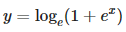

In [14]:
def log1pexp(x):
    return tf.math.log(1 + tf.exp(x))

The derivative of y is:

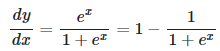

Theoretically, if x = 100, dy/dx should be 1. However, due to numerical instability, the gradient this function evaluated at x=100 is NaN. For example:

In [34]:
x = tf.constant(100.)
with tf.GradientTape() as g:
    g.watch(x)
    y = log1pexp(x)
    dy = g.gradient(y, x) # Will be evaluated as NaN
print("dy/dx =", dy.numpy())

dy/dx = 1.0


The gradient expression can be analytically simplified to provide numerical stability:

In [21]:
@tf.custom_gradient
def log1pexp(x):
    e = tf.exp(x)
    def grad(dy):
        return dy * (1 - 1 / (1 + e))
    return tf.math.log(1 + e), grad

In [24]:
x = tf.constant(10.)
with tf.GradientTape() as g:
    g.watch(x)
    y = log1pexp(x)
    tf.print(y)
dy = g.gradient(y, x) # Will be evaluated as 1.0
print("dy/dx =", dy.numpy())

10.0000458
dy/dx = 0.9999546
